In [1]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket='<bax452>'

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 964 ms, sys: 180 ms, total: 1.14 s
Wall time: 2.04 s


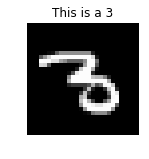

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

In [4]:
data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

training data will be uploaded to: s3://<bax452>/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://<bax452>/kmeans_example/output


In [5]:
from time import time              
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
start_time = time()
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
# define graph input 
# mnist image shape 28*28=784
# 0-9 digits have 10 classes

x = tf.placeholder(tf.float32, [None, 784])

#define output label
y_label = tf.placeholder(tf.float32, [None, 10])

# define weights
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# define model -Softmax function

y_predict = tf.nn.softmax(tf.matmul(x, W) + b)

In [8]:
# Minimize error using cross entropy
cross_entropy  = tf.reduce_mean(-tf.reduce_sum( y_label * tf.log(y_predict), reduction_indices=1))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cross_entropy)

In [9]:
# Initialize
init = tf.global_variables_initializer()
sess = tf.InteractiveSession() 
sess.run(init)

In [10]:
# train 1000 times
# Test model accuracy
# total time used in training and prediction

for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(optimizer, feed_dict={x: batch_xs, y_label: batch_ys})
correct_predict = tf.equal(tf.argmax(y_predict,1), tf.argmax(y_label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predict, dtype='float'))
print('Accuracy:',sess.run(accuracy, feed_dict={x: mnist.test.images, y_label: mnist.test.labels}))
print('Training and Modeling time：%.3f' %(time() - start_time)+'sec')
sess.close()


Accuracy: 0.9166
Training and Modeling time：2.043sec
